#  Ubiquant Market Prediction with DNN
## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats

## Import dataset

In [2]:
%%time
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train = pd.read_pickle('../input/ubiquant-market-prediction-half-precision-pickle/train.pkl')
train.head()

CPU times: user 449 ms, sys: 1.52 s, total: 1.97 s
Wall time: 18 s


,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


In [3]:
investment_id = train.pop("investment_id")
investment_id.head()

0    1
1    2
2    6
3    7
4    8
Name: investment_id, dtype: uint16

In [4]:
_ = train.pop("time_id")

In [5]:
y = train.pop("target")
y.head()

0   -0.300781
1   -0.231079
2    0.568848
3   -1.064453
4   -0.531738
Name: target, dtype: float16

## Create a IntegerLookup layer for investment_id input

In [6]:
%%time
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

2022-01-26 10:46:16.171688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 10:46:16.281007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 10:46:16.281706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 10:46:16.282818: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

CPU times: user 846 ms, sys: 624 ms, total: 1.47 s
Wall time: 2.74 s


## Make Tensorflow dataset

In [7]:
import tensorflow as tf
def preprocess(X, y):
    return X, y
def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(4096)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## Modeling

In [8]:
def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse])
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

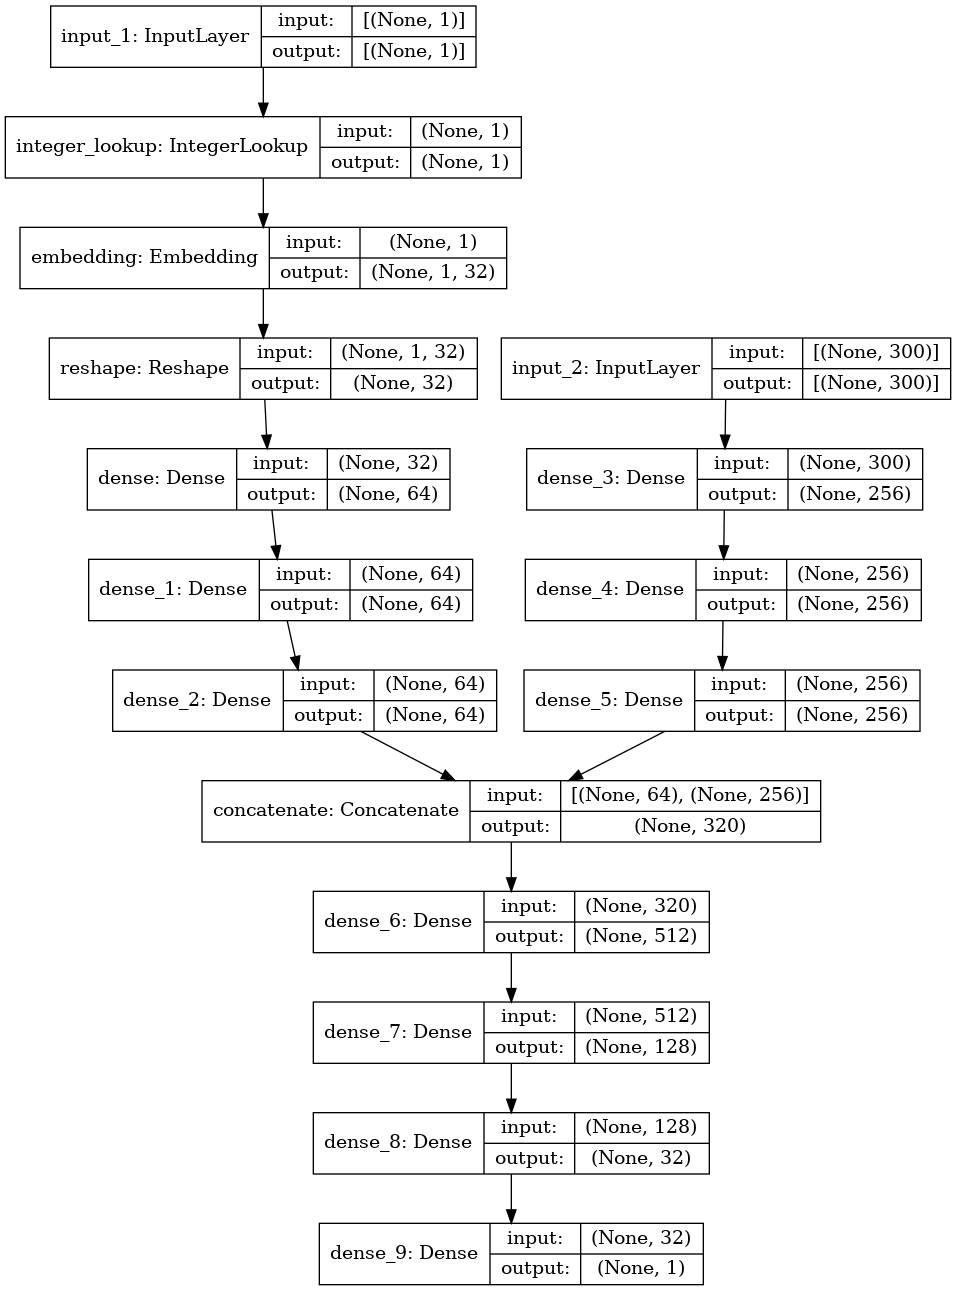

In [9]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
2022-01-26 10:46:33.225984: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.
2022-01-26 10:46:34.820703: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.
2022-01-26 10:46:37.069230: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.
2022-01-26 10:46:38.015411: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.


Epoch 1/30
2455/2455 [==============================] - 25s 9ms/step - loss: 0.9098 - mse: 0.8315 - mae: 0.6245 - mape: 124581.3047 - rmse: 0.9119 - val_loss: 0.8408 - val_mse: 0.8390 - val_mae: 0.6289 - val_mape: 193677.1875 - val_rmse: 0.9160


2022-01-26 10:47:05.231171: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-01-26 10:47:07.002557: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.


Epoch 2/30
2455/2455 [==============================] - 15s 6ms/step - loss: 0.8310 - mse: 0.8271 - mae: 0.6229 - mape: 139701.2031 - rmse: 0.9095 - val_loss: 0.8407 - val_mse: 0.8373 - val_mae: 0.6285 - val_mape: 182052.1250 - val_rmse: 0.9151
Epoch 3/30
2455/2455 [==============================] - 15s 6ms/step - loss: 0.8292 - mse: 0.8237 - mae: 0.6215 - mape: 148401.0156 - rmse: 0.9076 - val_loss: 0.8393 - val_mse: 0.8377 - val_mae: 0.6283 - val_mape: 195322.5156 - val_rmse: 0.9152
Epoch 4/30
2455/2455 [==============================] - 15s 6ms/step - loss: 0.8280 - mse: 0.8220 - mae: 0.6208 - mape: 144912.2656 - rmse: 0.9067 - val_loss: 0.8388 - val_mse: 0.8368 - val_mae: 0.6289 - val_mape: 158368.1875 - val_rmse: 0.9148
Epoch 5/30
2455/2455 [==============================] - 14s 6ms/step - loss: 0.8261 - mse: 0.8193 - mae: 0.6198 - mape: 143892.7188 - rmse: 0.9052 - val_loss: 0.8389 - val_mse: 0.8365 - val_mae: 0.6289 - val_mape: 134672.0781 - val_rmse: 0.9146
Epoch 6/30
2455/2455

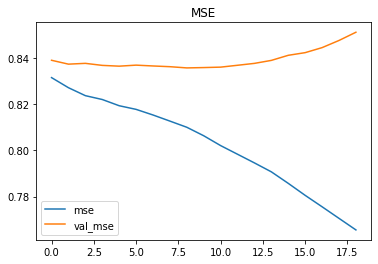

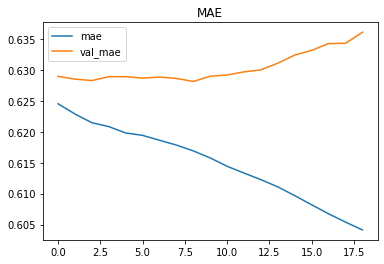

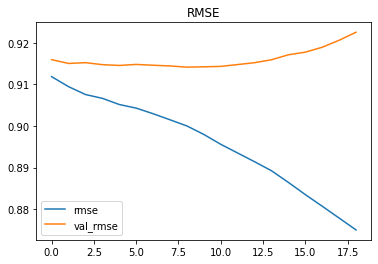

CPU times: user 6min 49s, sys: 59.5 s, total: 7min 48s
Wall time: 6min 33s


In [10]:
%%time
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = get_model()
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    models.append(keras.models.load_model(f"model_{index}"))
    
    pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    plt.title("MSE")
    plt.show()
    pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    plt.title("MAE")
    plt.show()
    pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
    plt.title("RMSE")
    plt.show()
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    gc.collect()
    break

## Submission

In [11]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0
def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [12]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df) 

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
